# Notebook 05: Clustering Ablation (All Features)

This run tests whether using the **full engineered feature set** gives cleaner clusters than the PCA-based matrix from Notebook 04.

Tone check: this is an experiment notebook, not a forced-win notebook. If results are weak, we call it out plainly.


---

## Setup + Runtime Config

In [1]:
import json
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

# Runtime knobs
SKIP_K2 = True
USE_MINIBATCH_FOR_FULL_FIT = True
K_RANGE = list(range(2, 11))
GRID_SAMPLE_N = 60000
EVAL_SAMPLE_N = 25000
WINSOR_LO = 0.005
WINSOR_HI = 0.995

INPUT_PATH = Path('data/features/feature_matrix.parquet')
BASELINE_PATH = Path('data/clusters/clustering_metrics.csv')
OUTPUT_DIR = Path('data/clusters/ablation_all_features')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

print('Runtime config:')
print(f'  SKIP_K2: {SKIP_K2}')
print(f'  USE_MINIBATCH_FOR_FULL_FIT: {USE_MINIBATCH_FOR_FULL_FIT}')
print(f'  GRID_SAMPLE_N: {GRID_SAMPLE_N:,}')
print(f'  EVAL_SAMPLE_N: {EVAL_SAMPLE_N:,}')
print(f'  K_RANGE: {K_RANGE}')


Runtime config:
  SKIP_K2: True
  USE_MINIBATCH_FOR_FULL_FIT: True
  GRID_SAMPLE_N: 60,000
  EVAL_SAMPLE_N: 25,000
  K_RANGE: [2, 3, 4, 5, 6, 7, 8, 9, 10]


---

## 1) Load Full Feature Matrix

In [2]:
features = pd.read_parquet(INPUT_PATH).copy()

print('Loaded feature matrix:')
print(f'  shape: {features.shape}')
print(f'  index name: {features.index.name}')

aisle_cols = [c for c in features.columns if c.lower().startswith('aisle_')]
non_aisle_cols = [c for c in features.columns if not c.lower().startswith('aisle_')]

print(f'  aisle features: {len(aisle_cols)}')
print(f'  non-aisle features: {len(non_aisle_cols)}')

missing = int(features.isna().sum().sum())
inf = int(np.isinf(features.values).sum())
print(f'  missing values: {missing}')
print(f'  inf values: {inf}')

assert missing == 0, 'Missing values found in feature matrix.'
assert inf == 0, 'Infinite values found in feature matrix.'


Loaded feature matrix:
  shape: (182223, 149)
  index name: user_id
  aisle features: 135
  non-aisle features: 14
  missing values: 0
  inf values: 0


---

## 2) Preprocess (Winsorize + Scale)

We clip extreme tails first, then standardize. This keeps outliers from dominating distance-based clustering.


In [3]:
q_lo = features.quantile(WINSOR_LO)
q_hi = features.quantile(WINSOR_HI)
X_clipped = features.clip(lower=q_lo, upper=q_hi, axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X_clipped.values)
user_ids = features.index.to_numpy()

print('Preprocessing complete:')
print(f'  X shape: {X.shape}')
print(f'  mean(abs): {np.abs(X.mean(axis=0)).mean():.4e}')
print(f'  std(avg): {X.std(axis=0).mean():.4f}')


Preprocessing complete:
  X shape: (182223, 149)
  mean(abs): 6.0496e-17
  std(avg): 1.0000


---

## 3) K Search on Sample

In [4]:
sample_n = min(GRID_SAMPLE_N, len(X))
sample_idx = rng.choice(len(X), sample_n, replace=False)
X_grid = X[sample_idx]

rows = []
for k in K_RANGE:
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=10, max_iter=300)
    labels = km.fit_predict(X_grid)

    sil = float(silhouette_score(X_grid, labels))
    ch = float(calinski_harabasz_score(X_grid, labels))
    db = float(davies_bouldin_score(X_grid, labels))
    sizes = Counter(labels)
    min_pct = float(min(sizes.values()) / len(labels) * 100)
    max_pct = float(max(sizes.values()) / len(labels) * 100)

    rows.append({
        'k': k,
        'silhouette': sil,
        'calinski_harabasz': ch,
        'davies_bouldin': db,
        'min_cluster_pct': min_pct,
        'max_cluster_pct': max_pct,
    })
    print(f'k={k}: silhouette={sil:.3f}, min_cluster={min_pct:.1f}%')

results_df = pd.DataFrame(rows).sort_values(['silhouette', 'min_cluster_pct'], ascending=[False, False]).reset_index(drop=True)
results_df.to_csv(OUTPUT_DIR / 'k_search_all_features.csv', index=False)

print('\nTop candidates:')
print(results_df.head(8).to_string(index=False))


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu

k=2: silhouette=0.065, min_cluster=37.9%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=3: silhouette=0.038, min_cluster=11.7%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=4: silhouette=-0.008, min_cluster=8.4%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=5: silhouette=-0.027, min_cluster=5.8%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=6: silhouette=-0.024, min_cluster=2.2%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=7: silhouette=-0.025, min_cluster=2.2%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=8: silhouette=-0.021, min_cluster=2.1%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=9: silhouette=-0.021, min_cluster=1.0%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

k=10: silhouette=-0.020, min_cluster=1.3%

Top candidates:
 k  silhouette  calinski_harabasz  davies_bouldin  min_cluster_pct  max_cluster_pct
 2    0.065075        1690.106554        5.680347        37.856667        62.143333
 3    0.037866        1352.116886        5.106636        11.716667        55.881667
 4   -0.007822        1188.779618        5.359816         8.445000        38.721667
10   -0.020012         724.881221        4.577958         1.270000        20.880000
 8   -0.020712         829.767303        4.978215         2.063333        21.773333
 9   -0.021451         775.284936        4.698633         0.993333        21.233333
 6   -0.024242         980.324084        5.086905         2.178333        29.030000
 7   -0.024719         891.444987        5.145725         2.236667        21.603333


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

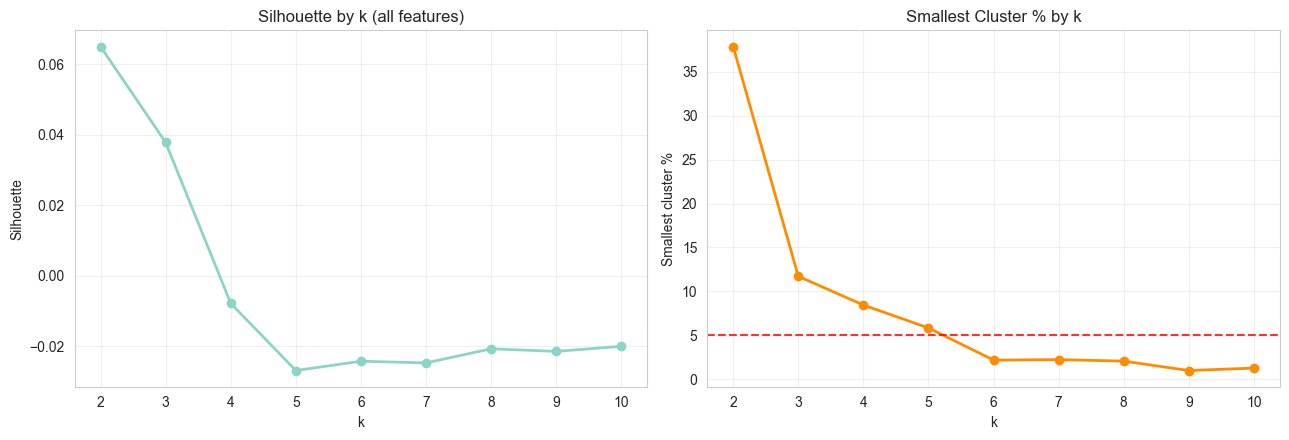

In [5]:
plot_df = results_df.sort_values('k')
fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))

axes[0].plot(plot_df['k'], plot_df['silhouette'], marker='o', linewidth=2)
axes[0].set_title('Silhouette by k (all features)')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Silhouette')
axes[0].grid(alpha=0.3)

axes[1].plot(plot_df['k'], plot_df['min_cluster_pct'], marker='o', linewidth=2, color='darkorange')
axes[1].axhline(5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
axes[1].set_title('Smallest Cluster % by k')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Smallest cluster %')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'k_search_all_features.png', dpi=150, bbox_inches='tight')
plt.show()


---

## 4) Select k (with optional skip for k=2)

In [6]:
if SKIP_K2:
    candidates = results_df[results_df['k'] > 2].reset_index(drop=True)
    if len(candidates) > 0:
        best = candidates.iloc[0]
        print('Selection rule: skipped k=2, picked next best candidate.')
    else:
        best = results_df.iloc[0]
        print('Fallback: no k>2 candidate; using top overall.')
else:
    best = results_df.iloc[0]
    print('Selection rule: k=2 allowed, using top overall.')

optimal_k = int(best['k'])
print(f'Optimal k: {optimal_k}')
print(f"Silhouette (grid sample): {best['silhouette']:.3f}")


Selection rule: skipped k=2, picked next best candidate.
Optimal k: 3
Silhouette (grid sample): 0.038


---

## 5) Fit Final Model on Full Data

In [7]:
if USE_MINIBATCH_FOR_FULL_FIT:
    final_model = MiniBatchKMeans(
        n_clusters=optimal_k,
        random_state=RANDOM_SEED,
        batch_size=4096,
        n_init=10,
        max_iter=300,
    )
else:
    final_model = KMeans(n_clusters=optimal_k, random_state=RANDOM_SEED, n_init=10, max_iter=300)

final_labels = final_model.fit_predict(X)
sizes = Counter(final_labels)
min_pct_full = float(min(sizes.values()) / len(final_labels) * 100)

eval_n = min(EVAL_SAMPLE_N, len(X))
eval_idx = rng.choice(len(X), eval_n, replace=False)
X_eval = X[eval_idx]
y_eval = final_labels[eval_idx]

final_sil = float(silhouette_score(X_eval, y_eval))
final_ch = float(calinski_harabasz_score(X_eval, y_eval))
final_db = float(davies_bouldin_score(X_eval, y_eval))

print('Final model metrics (sampled eval):')
print(f'  silhouette: {final_sil:.4f}')
print(f'  calinski_harabasz: {final_ch:.2f}')
print(f'  davies_bouldin: {final_db:.4f}')
print(f'  smallest cluster % (full labels): {min_pct_full:.2f}')

labels_df = pd.DataFrame({'user_id': user_ids, 'cluster': final_labels})
labels_df.to_parquet(OUTPUT_DIR / 'cluster_labels_all_features.parquet', index=False)

centers_df = pd.DataFrame(final_model.cluster_centers_, columns=features.columns)
centers_df.to_csv(OUTPUT_DIR / 'cluster_centers_all_features.csv', index=False)

metrics_df = pd.DataFrame([{
    'feature_set': 'all_features',
    'n_features': int(X.shape[1]),
    'n_clusters': int(optimal_k),
    'silhouette_score': final_sil,
    'calinski_harabasz': final_ch,
    'davies_bouldin': final_db,
    'smallest_cluster_pct': min_pct_full,
    'k2_skipped': bool(SKIP_K2),
    'grid_sample_n': int(sample_n),
    'eval_sample_n': int(eval_n),
    'winsor_lo': float(WINSOR_LO),
    'winsor_hi': float(WINSOR_HI),
    'algo_full_fit': type(final_model).__name__,
}])
metrics_df.to_csv(OUTPUT_DIR / 'clustering_metrics_all_features.csv', index=False)

print('\nSaved:')
print(f'  {OUTPUT_DIR / "cluster_labels_all_features.parquet"}')
print(f'  {OUTPUT_DIR / "cluster_centers_all_features.csv"}')
print(f'  {OUTPUT_DIR / "clustering_metrics_all_features.csv"}')


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  cu

Final model metrics (sampled eval):
  silhouette: -0.0080
  calinski_harabasz: 523.83
  davies_bouldin: 5.8624
  smallest cluster % (full labels): 32.12

Saved:
  data/clusters/ablation_all_features/cluster_labels_all_features.parquet
  data/clusters/ablation_all_features/cluster_centers_all_features.csv
  data/clusters/ablation_all_features/clustering_metrics_all_features.csv


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/adeliaramp/Documents/

---

## 6) Compare Against Notebook 04 Baseline

In [8]:
if BASELINE_PATH.exists():
    base = pd.read_csv(BASELINE_PATH).iloc[0]
    base_sil = float(base['silhouette_score'])
    diff = final_sil - base_sil
    rel = (diff / base_sil * 100) if base_sil != 0 else np.nan

    print('Baseline (Notebook 04):')
    print(f'  algorithm: {base["algorithm_selected"]}')
    print(f'  feature_set: {base["matrix_variant"]}')
    print(f'  silhouette: {base_sil:.4f}')

    print('\nAll-features ablation:')
    print(f'  silhouette: {final_sil:.4f}')
    print(f'  delta: {diff:+.4f} ({rel:+.2f}%)')
else:
    print('Baseline metrics not found. Skipping comparison.')


Baseline (Notebook 04):
  algorithm: KMeans
  feature_set: pruned
  silhouette: 0.1049

All-features ablation:
  silhouette: -0.0080
  delta: -0.1129 (-107.63%)


## Wrap-up Notes

- If silhouette is still around `~0.10`, that means structure is still weak even with all features.
- If it improves meaningfully, inspect cluster centers and check whether differences are business-usable (frequency, loyalty, reorder cadence).
- Next notebook (`06`) isolates **non-aisle features** to test if aisle sparsity/noise is diluting separability.
